In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout, UpSampling2D, Add, Activation, Multiply, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Define dataset path
dataset_path = "/content/drive/MyDrive/Dataset/DatasetFor2/Semantic segmentation dataset"

# Get all directories except 'classes.json'
dataset_dirs = sorted([d for d in os.listdir(dataset_path) if d != "classes.json"])

def fetch_images(base_path, sub_dir):
    img_list, mask_list = [], []
    sub_path = os.path.join(base_path, sub_dir)

    input_folder, mask_folder = os.listdir(sub_path)
    input_images = sorted(os.listdir(os.path.join(sub_path, input_folder)))
    mask_images = sorted(os.listdir(os.path.join(sub_path, mask_folder)))

    for image in input_images:
        img_path = os.path.join(sub_path, input_folder, image)
        img = load_img(img_path, target_size=(224, 224))
        img = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0
        img_list.append(img)

    for mask in mask_images:
        mask_path = os.path.join(sub_path, mask_folder, mask)
        mask_img = load_img(mask_path, target_size=(224, 224))
        mask_img = tf.convert_to_tensor(mask_img, dtype=tf.float32) / 255.0
        mask_list.append(mask_img)

    return img_list, mask_list

def load_dataset(base_path, directories):
    img_data, mask_data = [], []
    for folder in directories:
        images, masks = fetch_images(base_path, folder)
        img_data.extend(images)
        mask_data.extend(masks)
    return img_data, mask_data

# Load images and masks
images, masks = load_dataset(dataset_path, dataset_dirs)


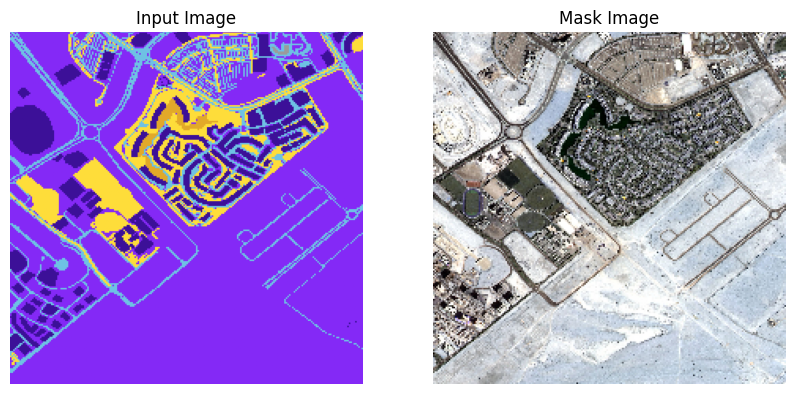

In [3]:
train_imgs, test_imgs, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, shuffle=True, random_state=42)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(train_imgs[1])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask Image")
plt.imshow(train_masks[1])
plt.axis("off")

plt.show()


In [4]:
train_data = np.array(list(zip(train_imgs, train_masks)))
test_data = np.array(list(zip(test_imgs, test_masks)))


In [5]:
def attention_module(skip_conn, gating_signal, filters):
    theta = Conv2D(filters, kernel_size=1, padding='same')(skip_conn)
    phi = Conv2D(filters, kernel_size=1, padding='same')(gating_signal)
    add = Add()([theta, phi])
    activated = Activation('relu')(add)
    psi = Conv2D(1, kernel_size=1, padding='same')(activated)
    sigmoid_output = Activation('sigmoid')(psi)
    return Multiply()([skip_conn, sigmoid_output])


In [6]:
def encoder_block(x, dropout_rate, filters):
    x = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    pooled = MaxPooling2D(pool_size=(2, 2))(x)
    return x, pooled

def decoder_block(x, skip_conn, dropout_rate, filters):
    x = UpSampling2D(size=(2, 2))(x)
    attention = attention_module(skip_conn, x, filters)
    x = Concatenate(axis=-1)([attention, x])
    x = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    return x


In [7]:
def build_unet(input_layer, dropout_rate=0.1, filters_list=[32, 64, 128, 256, 512]):
    # Encoder
    conv1, pool1 = encoder_block(input_layer, dropout_rate, filters_list[0])
    conv2, pool2 = encoder_block(pool1, dropout_rate, filters_list[1])
    conv3, pool3 = encoder_block(pool2, dropout_rate, filters_list[2])
    conv4, pool4 = encoder_block(pool3, dropout_rate, filters_list[3])

    # Bottleneck
    bottleneck = Conv2D(filters_list[4], kernel_size=3, padding='same', activation='relu')(pool4)
    bottleneck = Dropout(dropout_rate)(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)

    # Decoder
    up6 = decoder_block(bottleneck, conv4, dropout_rate, filters_list[3])
    up7 = decoder_block(up6, conv3, dropout_rate, filters_list[2])
    up8 = decoder_block(up7, conv2, dropout_rate, filters_list[1])
    up9 = decoder_block(up8, conv1, dropout_rate, filters_list[0])

    # Output layer
    final_output = Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid')(up9)

    return final_output


In [8]:
input_tensor = Input(shape=(224, 224, 3))
output_tensor = build_unet(input_tensor, dropout_rate=0.1)

unet_model = Model(inputs=input_tensor, outputs=output_tensor)
unet_model.summary()

unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = unet_model.fit(np.array(train_imgs), np.array(train_masks),
                         batch_size=8, epochs=10,
                         validation_data=(np.array(test_imgs), np.array(test_masks)))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 224, 224, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 112, 112, 64)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 56, 56, 128)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 128)    │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 5,755,367 (21.95 MB)

 Trainable params: 5,752,423 (21.94 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 152s 16s/step - accuracy: 0.3663 - loss: 0.7159 - val_accuracy: 0.4495 - val_loss: 0.7106
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 137s 16s/step - accuracy: 0.6074 - loss: 0.6086 - val_accuracy: 0.4493 - val_loss: 1.6735
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 134s 17s/step - accuracy: 0.6163 - loss: 0.5918 - val_accuracy: 0.4495 - val_loss: 1.5928
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 17s/step - accuracy: 0.6218 - loss: 0.5701 - val_accuracy: 0.4142 - val_loss: 0.8717
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 135s 16s/step - accuracy: 0.5233 - loss: 0.5780 - val_accuracy: 0.4305 - val_loss: 0.7190
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 145s 17s/step - accuracy: 0.5432 - loss: 0.5877 - val_accuracy: 0.4491 - val_loss: 1.0102
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 130s 16s/step - accuracy: 0.6371 - loss: 0.5805 - val_accuracy: 0.4939 - val_loss: 0.7769
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 16s/step - accuracy: 0.5807 - loss: 0.5817 - val_accuracy: 0.5014 - val_loss:

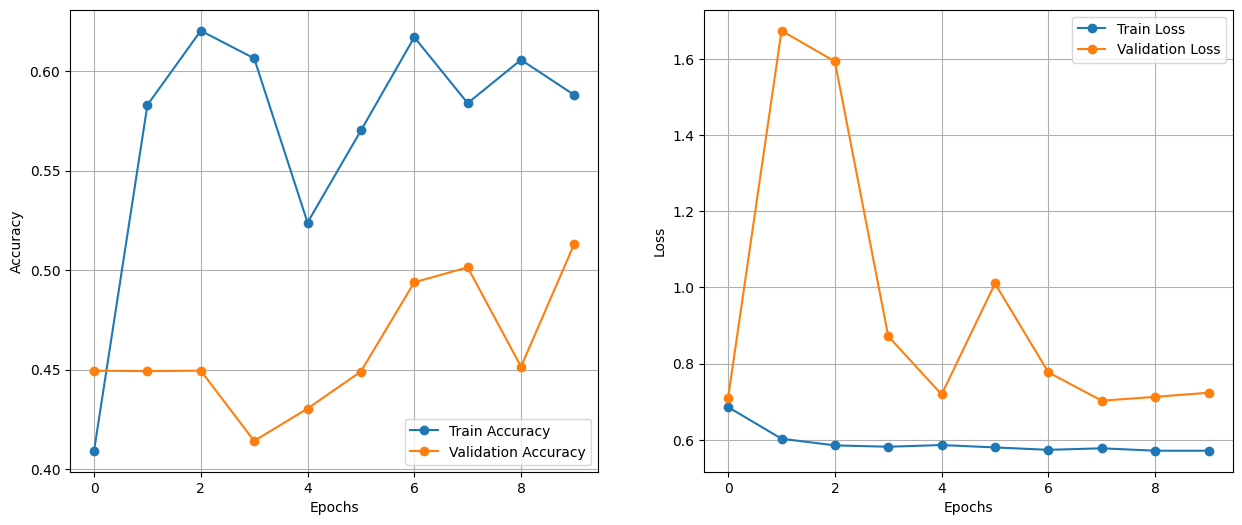

In [9]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', label='Train Loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


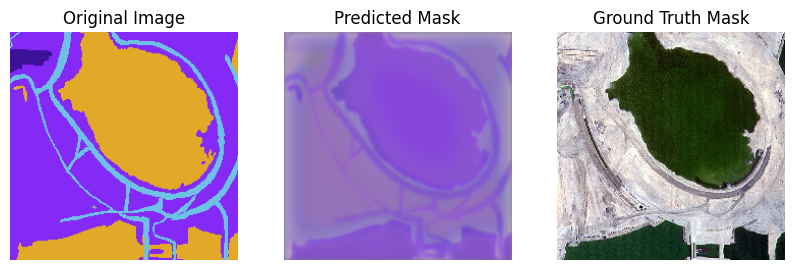

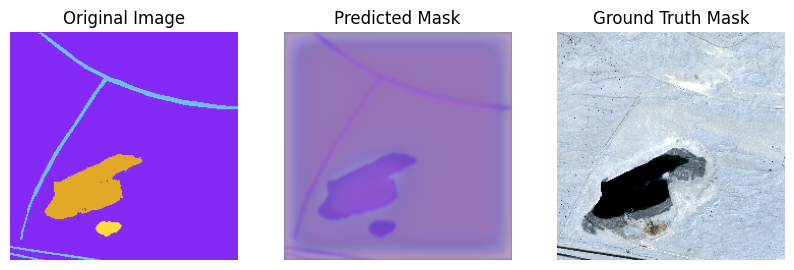

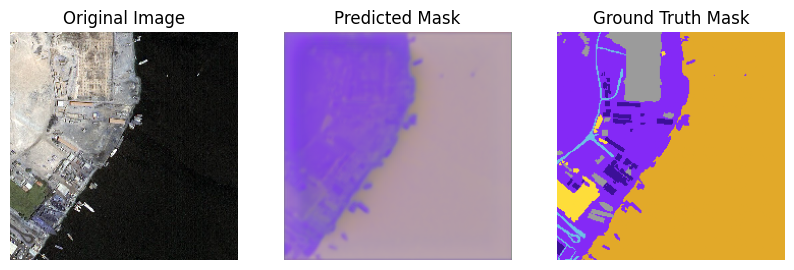

In [10]:
predicted_masks = unet_model.predict(np.array(test_imgs))

def display_predictions(index):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(test_imgs[index])
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(predicted_masks[index])
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")

    axes[2].imshow(test_masks[index])
    axes[2].set_title("Ground Truth Mask")
    axes[2].axis("off")

for idx in range(3):
    display_predictions(idx)
